使用的设备: cuda
>>> 正在加载数据...
✅ 数据加载成功！

>>> (重新) 预训练 GCNII 并记录 Loss 曲线...
✅ GCNII 预训练完成！

>>> 正在提取 GCNII 图嵌入特征...
提取的嵌入维度: (46564, 128)
>>> 正在拼接特征 (Raw + GCNII)...
混合特征矩阵形状: (46564, 293)

>>> 开始训练 XGBoost (Hybrid Mode: GCNII + Raw)...
\n==================== Hybrid Model (GCNII+XGB) 评估 ====================
              precision    recall  f1-score   support

       Licit       0.98      0.99      0.99     15587
     Illicit       0.89      0.68      0.77      1083

    accuracy                           0.97     16670
   macro avg       0.94      0.84      0.88     16670
weighted avg       0.97      0.97      0.97     16670

🔴 Hybrid F1-Score: 0.7721
🔴 Recall:        0.6805
🔴 Precision:     0.8923

(参考) 纯 XGBoost 基准 F1: 0.7257
(参考) 纯 GCNII 基准 F1: 0.6711 (来自文件06的运行结果)

>>> 正在生成详细分析图表...


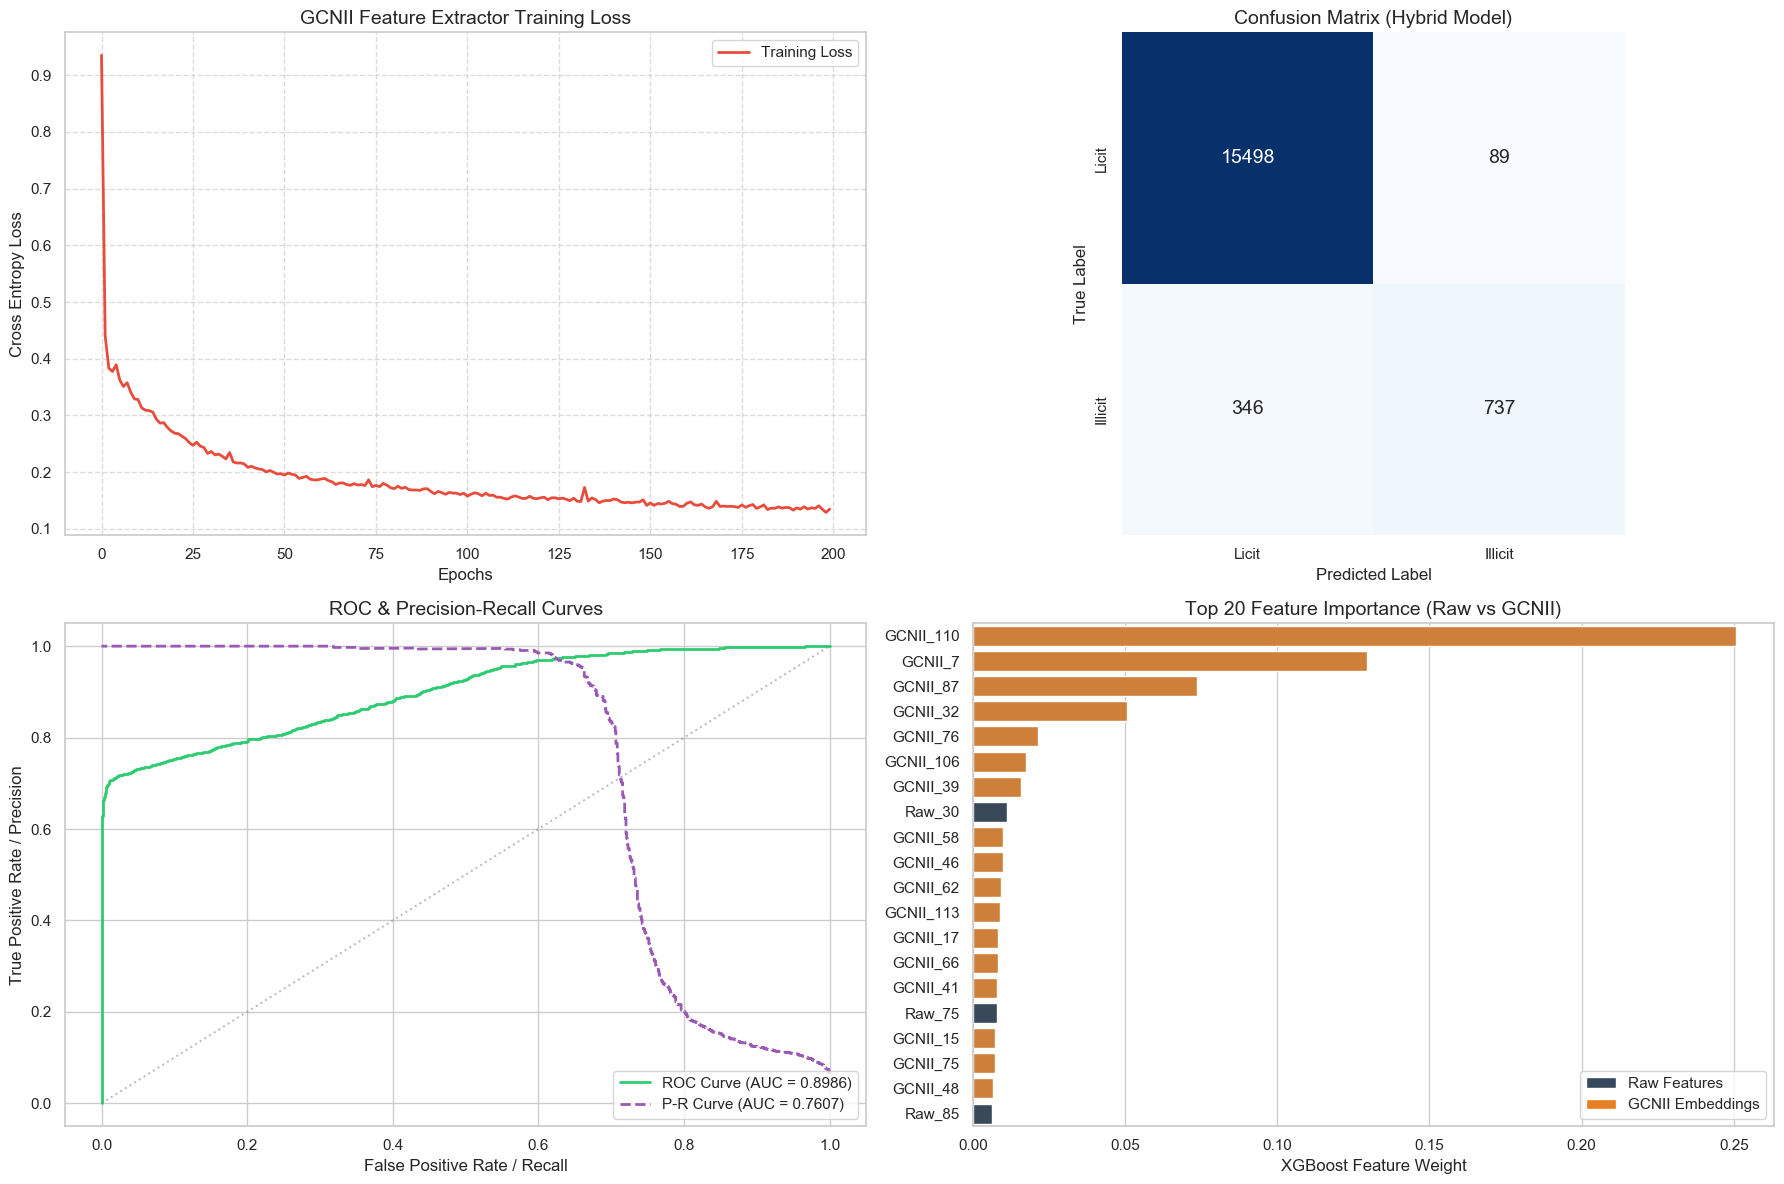

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GCN2Conv
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans'] # 适配中文
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {device}")

# ==========================================
# 1. 加载数据
# ==========================================
print(">>> 正在加载数据...")
try:
    data = torch.load('../data/processed/elliptic_pyg.pt', weights_only=False)
    data = data.to(device)
    print("✅ 数据加载成功！")
except FileNotFoundError:
    print("❌ 错误：找不到数据文件。")

# 计算正样本权重 (用于 GCNII 训练)
num_neg = (data.y[data.train_mask] == 0).sum().item()
num_pos = (data.y[data.train_mask] == 1).sum().item()
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

# ==========================================
# 2. 定义 DeepGCNII 模型
# ==========================================
# 核心思想：使用深层 GNN 提取节点的高阶邻域特征
class DeepGCNII(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=8, alpha=0.1, theta=0.5):
        super(DeepGCNII, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.convs = ModuleList()

        for i in range(num_layers):
            # layer=i+1 用于计算动态衰减系数 beta
            self.convs.append(GCN2Conv(hidden_channels, alpha, theta, layer=i+1))

        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        x_0 = x  # 保存初始特征 (Initial Residual)

        for conv in self.convs:
            x = conv(x, x_0, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin2(x)
        return x

    # 新增：提取嵌入特征的方法
    def get_embeddings(self, x, edge_index):
        # 这一步与 forward 前半部分一致，但在分类头 lin2 之前返回
        x = self.lin1(x)
        x_0 = x
        for conv in self.convs:
            x = conv(x, x_0, edge_index)
            x = F.relu(x)
        # 返回隐藏层特征，维度为 [num_nodes, hidden_channels]
        return x

# 初始化模型 (使用 8 层 GCNII，隐藏层 128 维)
# 相比 GAT，GCNII 可以堆叠更深而不发生过平滑
model = DeepGCNII(in_channels=data.num_features,
                  hidden_channels=128,
                  out_channels=2,
                  num_layers=8).to(device)

# ==========================================
# 3. 预训练 GCNII (提取有效特征的关键)
# ==========================================
# 只有训练过的 GNN 才能提取出具备判别力的特征
print("\n>>> (重新) 预训练 GCNII 并记录 Loss 曲线...")
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_history = [] # 新增：记录 loss
# 使用手动权重处理不平衡
loss_weights = torch.tensor([0.3, 0.7]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=loss_weights)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item()) # 记录

print("✅ GCNII 预训练完成！")

# ==========================================
# 4. 提取图嵌入 (Graph Embeddings)
# ==========================================
print("\n>>> 正在提取 GCNII 图嵌入特征...")
model.eval()
with torch.no_grad():
    # 调用我们新增的 get_embeddings 方法
    embeddings = model.get_embeddings(data.x, data.edge_index)
    embeddings_np = embeddings.cpu().numpy()

print(f"提取的嵌入维度: {embeddings_np.shape}") # (46564, 128)

# ==========================================
# 5. 拼接特征：原始特征 + GCNII 嵌入
# ==========================================
print(">>> 正在拼接特征 (Raw + GCNII)...")
raw_features = data.x.cpu().numpy()

# 水平拼接
X_hybrid = np.hstack([raw_features, embeddings_np])
print(f"混合特征矩阵形状: {X_hybrid.shape}") # (46564, 165 + 128 = 293)

# 准备数据标签
y = data.y.cpu().numpy()
train_mask = data.train_mask.cpu().numpy()
test_mask = data.test_mask.cpu().numpy()

X_train = X_hybrid[train_mask]
y_train = y[train_mask]
X_test = X_hybrid[test_mask]
y_test = y[test_mask]

# ==========================================
# 6. 训练 XGBoost (混合模型)
# ==========================================
print("\n>>> 开始训练 XGBoost (Hybrid Mode: GCNII + Raw)...")

# 计算 scale_pos_weight
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_weight = neg / pos

xgb_hybrid = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_weight,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

xgb_hybrid.fit(X_train, y_train)

# ==========================================
# 7. 评估结果
# ==========================================
print(f"\\n{'='*20} Hybrid Model (GCNII+XGB) 评估 {'='*20}")
y_pred = xgb_hybrid.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Licit', 'Illicit']))

f1 = f1_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
prec = precision_score(y_test, y_pred, pos_label=1)

print(f"🔴 Hybrid F1-Score: {f1:.4f}")
print(f"🔴 Recall:        {rec:.4f}")
print(f"🔴 Precision:     {prec:.4f}")

# 简单的对比输出
print(f"\n(参考) 纯 XGBoost 基准 F1: 0.7257")
print(f"(参考) 纯 GCNII 基准 F1: 0.6711 (来自文件06的运行结果)")

# ==========================================
# 8. 全面可视化分析
# ==========================================
print("\n>>> 正在生成详细分析图表...")

fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)

# --- 图 1: GCNII 特征提取器训练曲线 ---
ax1 = plt.subplot(2, 2, 1)
ax1.plot(loss_history, label='Training Loss', color='#e74c3c', linewidth=2)
ax1.set_title('GCNII Feature Extractor Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross Entropy Loss')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# --- 图 2: 混淆矩阵 (Confusion Matrix) ---
ax2 = plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, square=True,
            xticklabels=['Licit', 'Illicit'], yticklabels=['Licit', 'Illicit'],
            cbar=False, annot_kws={"size": 14, "weight": "bold"})
ax2.set_title('Confusion Matrix (Hybrid Model)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# --- 图 3: ROC 曲线 & P-R 曲线 ---
ax3 = plt.subplot(2, 2, 3)
# 计算概率
y_prob = xgb_hybrid.predict_proba(X_test)[:, 1]
# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
# PR
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

ax3.plot(fpr, tpr, color='#2ecc71', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax3.plot(recall, precision, color='#9b59b6', lw=2, linestyle='--', label=f'P-R Curve (AUC = {pr_auc:.4f})')
ax3.plot([0, 1], [0, 1], color='gray', linestyle=':', alpha=0.5)
ax3.set_title('ROC & Precision-Recall Curves', fontsize=14, fontweight='bold')
ax3.set_xlabel('False Positive Rate / Recall')
ax3.set_ylabel('True Positive Rate / Precision')
ax3.legend(loc='lower right')

# --- 图 4: 特征重要性分析 (Top 20) - 修正版 ---
ax4 = plt.subplot(2, 2, 4)

# 获取重要性
importances = xgb_hybrid.feature_importances_
# 构建特征名称
feat_names = [f"Raw_{i}" for i in range(165)] + [f"GCNII_{i}" for i in range(128)]
# 区分颜色
colors = ['#34495e' if "Raw" in name else '#e67e22' for name in feat_names]

# 创建 DataFrame 方便排序
df_imp = pd.DataFrame({'Feature': feat_names, 'Importance': importances, 'Color': colors})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(20) # 取前 20

# 🔥 修正点：添加 hue='Feature' 和 legend=False
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',     # 将 y 轴变量指定给 hue
    data=df_imp,
    palette=df_imp['Color'].tolist(),
    legend=False,      # 关闭自动生成的图例（因为我们下面手动加了图例）
    ax=ax4
)

ax4.set_title('Top 20 Feature Importance (Raw vs GCNII)', fontsize=14, fontweight='bold')
ax4.set_xlabel('XGBoost Feature Weight')
ax4.set_ylabel('')

# 添加图例说明
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#34495e', label='Raw Features'),
                   Patch(facecolor='#e67e22', label='GCNII Embeddings')]
ax4.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()